Прогноз цен акций на следующий день с помощью линейной регрессии.
Учитываем цены за последние N дней, обучаем модель и прогнозируем на N + 1 день.

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

In [81]:
stk_path = "VTI.csv"
test_size = 0.2                 # доля данных для теста
cv_size = 0.2                   # доля данных для кросс-валидации
Nmax = 30                       # Nmax - это максимальное значение N, которое мы собираемся протестировать

In [82]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Входы
         df: фрейм данных со значениями, которые вы хотите предсказать. Может быть любой длины.
         target_col: имя столбца, который вы хотите предсказать
         N: получить прогноз на временном шаге t, используя значения из t-1, t-2, ..., t-N
         pred_min: все прогнозы должны быть> = pred_min
         смещение: для df мы делаем прогнозы только для df[offset:]. Например смещение может быть размером обучающего набора
     Выходы
         pred_list: прогнозы для target_col. np.array длины len (df)-offset.
    """
    # Создание объекта линейной регрессии
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) 
        y_train = np.array(df['adj_close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
        y_train = y_train.reshape(-1, 1)
    
        regr.fit(X_train, y_train)            # Обучение модели
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Предсказание кол-ва шагов используя модель
    
    # Если значения меньше pred_min, установить их равными pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Вычисление средней абсолютной процентной ошибки (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [83]:
df = pd.read_csv(stk_path, sep = ",")

# Конвертация столбца Date в формат datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Изменить все заголовки столбцов на нижний регистр и удалить интервалы
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Получить месяц для каждой даты
df['month'] = df['date'].dt.month

# Сортировка по времени
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2019-12-27,164.610001,164.679993,163.800003,164.080002,161.210297,2356700,12
1,2019-12-30,164.300003,164.380005,162.910004,163.190002,160.335861,4503500,12
2,2019-12-31,163.000000,163.759995,162.720001,163.619995,160.758331,3262400,12
3,2020-01-02,164.679993,164.979996,163.779999,164.979996,162.094574,3291100,1
4,2020-01-03,163.289993,164.470001,163.009995,163.929993,161.062912,3625400,1
5,2020-01-06,162.919998,164.520004,162.830002,164.490005,161.613129,6813800,1
6,2020-01-07,164.270004,164.460007,163.779999,164.100006,161.229965,2498400,1
7,2020-01-08,164.199997,165.550003,164.039993,164.910004,162.025787,4244800,1
8,2020-01-09,165.809998,165.979996,165.360001,165.940002,163.037781,2216900,1
9,2020-01-10,166.259995,166.300003,165.199997,165.460007,162.566177,4023000,1


Text(0, 0.5, 'USD')

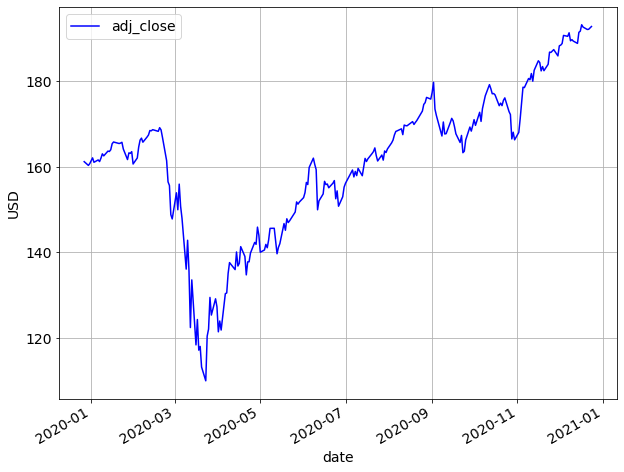

In [84]:
rcParams['figure.figsize'] = 10, 8 

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [85]:
# Получить размеры каждого датасета
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Разделение на тренировочную, резюмирующую и тестовую выборки
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 152
num_cv = 50
num_test = 50
train.shape = (152, 8)
cv.shape = (50, 8)
train_cv.shape = (202, 8)
test.shape = (50, 8)


Text(0, 0.5, 'USD')

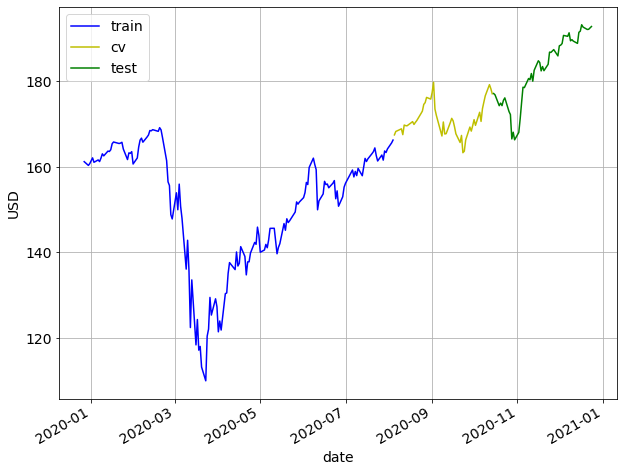

In [86]:
# График, показывающий как разделен датасет
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'cv', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

**Линейная регрессия**

In [87]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N - номер образцов для прогнозирования следующего значения
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [2.0194691864767687, 3.023753937957521, 2.3170777153775264, 2.295676672544984, 2.346802801310651, 2.4303574491385147, 2.597802536908458, 2.7387150844068207, 2.8517576177048154, 2.8812696574496206, 2.9118399444215917, 2.914797338015311, 2.9311386980689567, 2.9406631392528246, 2.9806357081633466, 3.046577790652877, 3.1482835454794267, 3.264255325347782, 3.3731588963400454, 3.486197634989813, 3.5818303915378933, 3.681958315135492, 3.780119062963791, 3.8849103122346507, 3.9990981833407937, 4.111567615047222, 4.231239398756704, 4.336341587276256, 4.42861790520635, 4.499557858070203]
R2 = [0.7163009013315467, 0.36397177613568554, 0.626522283504511, 0.6333894687192346, 0.6168783539666242, 0.5891116764060669, 0.5305430561583999, 0.4782322867030363, 0.43427064455265674, 0.4225009083484472, 0.4101813608941327, 0.40898266061846145, 0.40233718984661804, 0.39844678866211547, 0.3819817583585853, 0.35433382157125215, 0.3105049175305409, 0.2587721363136508, 0.20848874781469795, 0.15455083043279

,date,open,high,low,close,adj_close,volume,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
152,2020-08-05,168.479996,168.919998,168.300003,168.839996,167.469940,2683000,8,166.259842,166.914475,...,165.761067,165.648481,165.744533,165.844544,165.968823,166.215375,166.552292,166.543789,166.633705,166.395711
153,2020-08-06,168.619995,169.779999,168.279999,169.660004,168.283295,2150900,8,167.469940,168.680038,...,166.358512,166.423698,166.302498,166.381348,166.465857,166.575353,166.804220,167.122467,167.109736,167.192397
154,2020-08-07,169.220001,169.949997,168.600006,169.800003,168.422150,2193100,8,168.283295,169.096650,...,167.111685,167.072160,167.119296,166.989671,167.052162,167.121716,167.216801,167.428457,167.728444,167.710800
155,2020-08-10,170.029999,170.389999,169.050003,170.270004,168.888336,2496700,8,168.422150,168.561005,...,167.650137,167.741617,167.693452,167.728841,167.595715,167.646988,167.706159,167.790968,167.989388,168.274806
156,2020-08-11,171.000000,171.330002,168.479996,168.899994,167.529449,3124600,8,168.888336,169.354522,...,168.313518,168.270537,168.348252,168.293784,168.319792,168.184651,168.226659,168.277149,168.353210,168.539970


(1.0, 30.0)

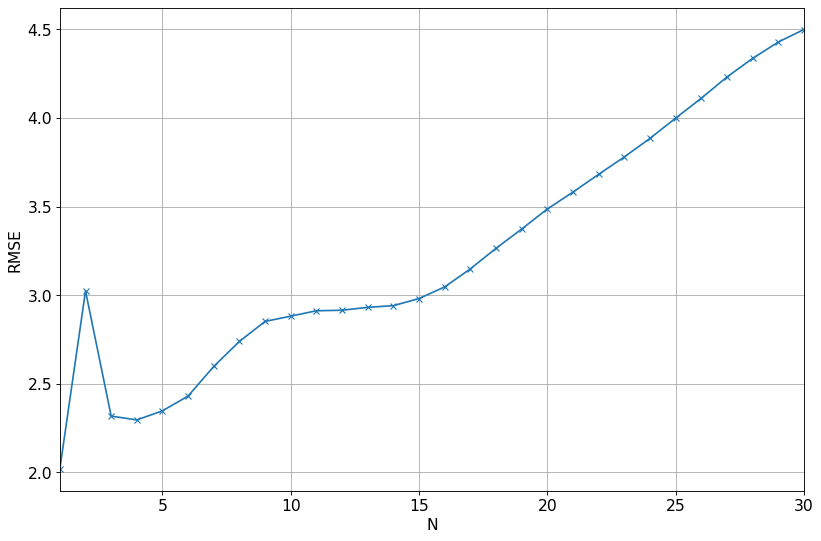

In [88]:
# График зависимости RMSE от N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([1, 30])

Наименьшее RMSE достигается при N = 1, за которым следует N = 4.

Text(0, 0.5, 'R2')

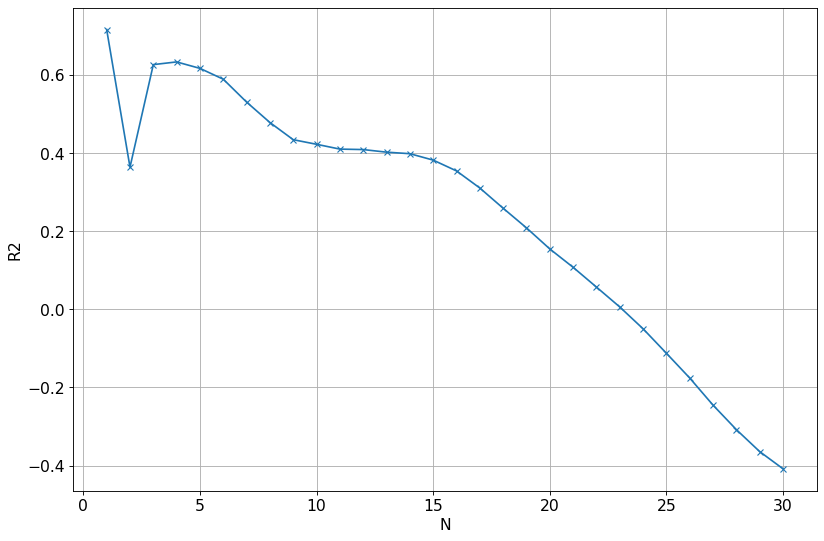

In [89]:
# График зависимости R2 от N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

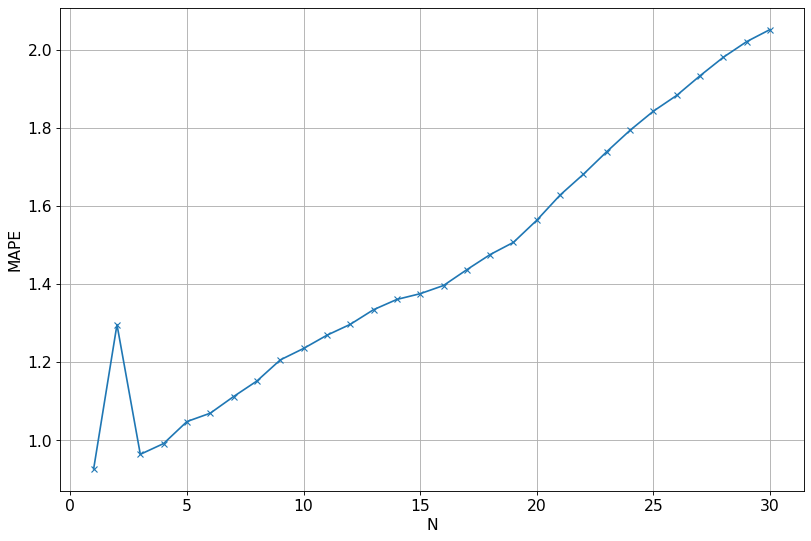

In [90]:
# График зависимости MAPE от N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [91]:
# устанавливаем оптимальное значение N
N_opt = 4

Строим прогноз на определенный день

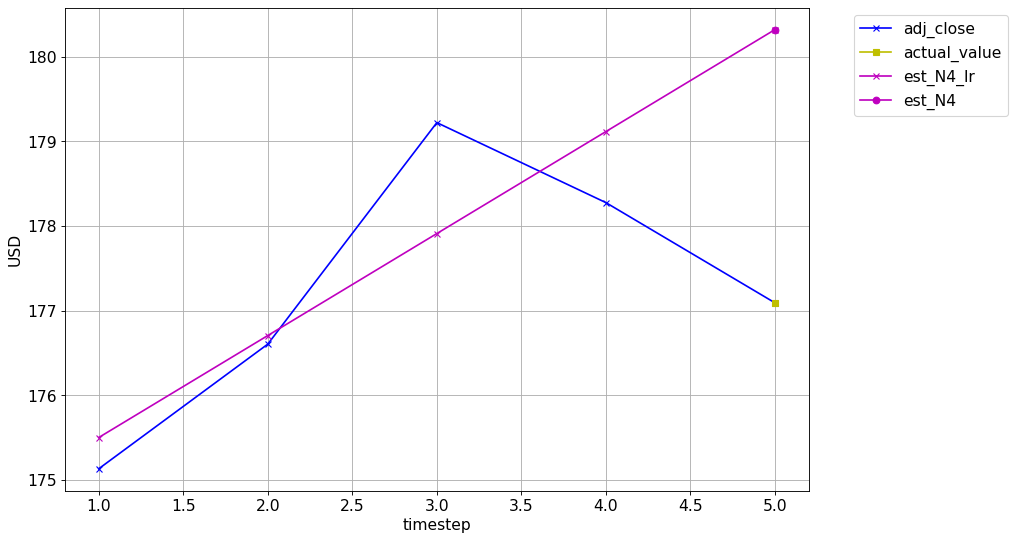

In [92]:
# Указываем любой день
day = pd.Timestamp(date(2020, 12, 28))

# максимальное значение N, которое хотим построить
Nmax2 = 4

df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['adj_close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['adj_close'], 'ys-')
legend_list = ['adj_close', 'actual_value']

# Построим линии линейной регрессии и прогнозы
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Создаем объект линейной регрессии
for N in range(4, Nmax2+1):
    # Строим линии линейной регрессии
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) 
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) 
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Тренируем модель
    y_est = regr.predict(X_train)         # Получим линию линейной регрессии
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Строим прогноз
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))

Прогнозируем на дев датасете

Text(0, 0.5, 'USD')

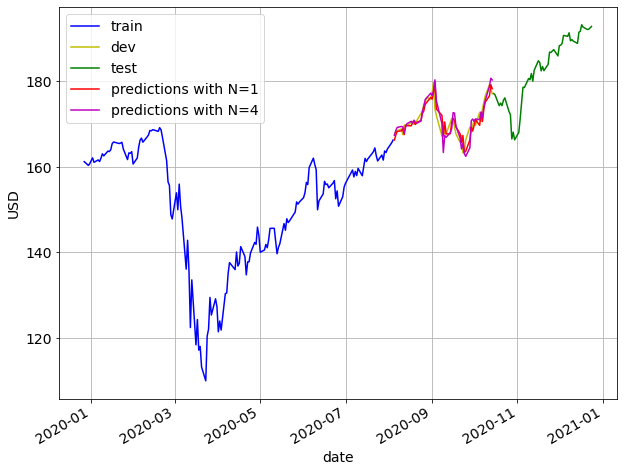

In [93]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N4', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

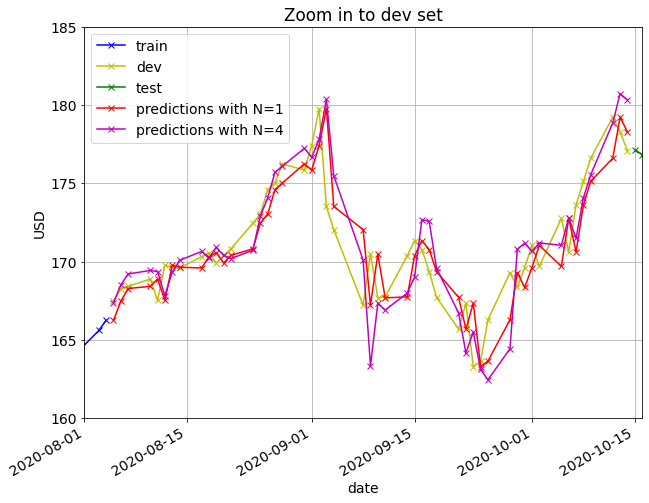

In [94]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N4', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 8, 1), date(2020, 10, 16)])
ax.set_ylim([160, 185])
ax.set_title('Zoom in to dev set')

**Финальная модель**

In [95]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 2.036
R2 = 0.932
MAPE = 0.897%


,date,open,high,low,close,adj_close,volume,month,est_N4
202,2020-10-15,175.610001,178.070007,175.160004,177.869995,177.150345,2865300,10,177.927192
203,2020-10-16,178.479996,179.309998,177.550003,177.550003,176.831650,1910200,10,176.084678
204,2020-10-19,178.309998,179.250000,174.619995,175.009995,174.301910,2713800,10,176.268936
205,2020-10-20,175.899994,177.360001,175.240005,175.619995,174.909439,2622900,10,174.172440
206,2020-10-21,175.660004,176.720001,175.020004,175.020004,174.311874,3237200,10,173.485221


Text(0, 0.5, 'USD')

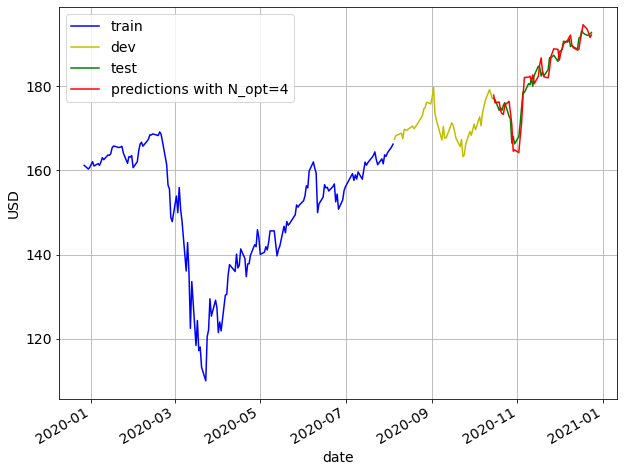

In [96]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N4', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

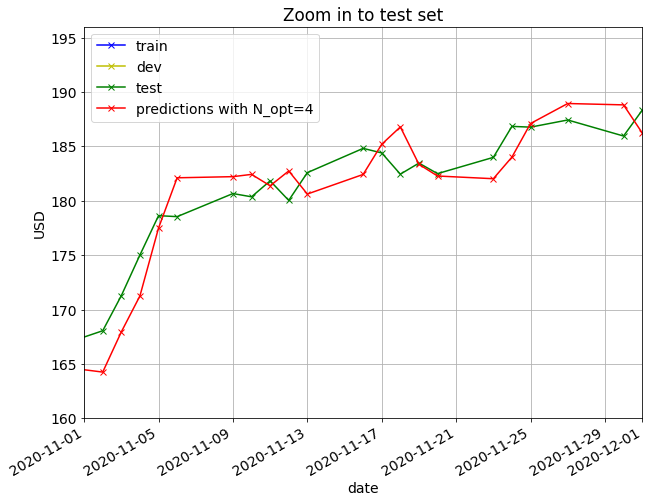

In [97]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N4', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 11, 1), date(2020, 12, 1)])
ax.set_ylim([160, 196])
ax.set_title('Zoom in to test set')

(160.0, 196.0)

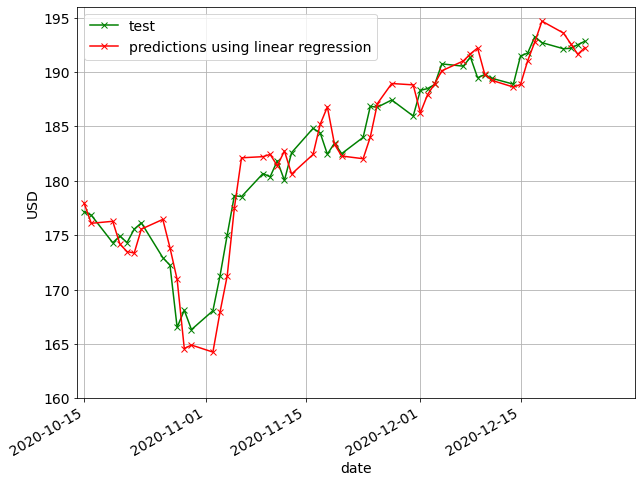

In [98]:
rcParams['figure.figsize'] = 10, 8 

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N4', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 10, 14), date(2020, 12, 31)])
ax.set_ylim([160, 196])

In [99]:
test_lin_reg = test
test_lin_reg.to_csv("test_lin_reg.csv")